# DAFI's Covariance Module
This document shows the use of DAFI's covariance module *dafi.random_field.covariance* to create a covariance matrix.

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from dafi import random_field as rf

%matplotlib inline

mpl.rcParams.update({'text.usetex': True, 
    'text.latex.preamble': ['\\usepackage{gensymb}'], })

## 1D Example
First create the mesh. 

In [2]:
ncells = 100
L = 1.0 
x = np.linspace(0.0, L, ncells)
dx = x[1] - x[0] # equal spacing

### Correlation Structure
Next create the correlation structure. Here we will use a square exponential kernel with a length scale $10\%$ of the domain length. 

In [3]:
l = 0.1*L
corr = rf.covariance.kernel_sqrexp(coords=x, length_scales=l)

We can check that the correlation matrix is a proper correlation matrix, that is:
* Symmetric
* Positive definite
* Diagonal = 1
* Off Diagonal between -1 and 1

In [4]:
passed, message = rf.covariance.check_mat(corr, type='corr')
print(passed)
if not passed:
    print(message)

True


Plot the correlation. Each point is highly correlated to points nearby.

Text(0.5, 1.05, 'Square Exponential Correlation')

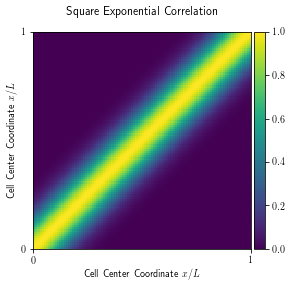

In [5]:
# plotting  function
def plot_mat(mat):
    ncells = mat.shape[0]
    fig, ax = plt.subplots()
    im = ax.matshow(np.flipud(mat), extent=[0,1,0,1], interpolation='none')
    ax.xaxis.tick_bottom()
    ax.set_xlabel('Cell Center Coordinate $x/L$')
    ax.set_ylabel('Cell Center Coordinate $x/L$')
    ax.set_aspect('equal')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    return fig, ax

# plot
fig, ax = plot_mat(corr)
ax.set_title('Square Exponential Correlation')

#### Sparse matrices
We can also convert the correlation matrix to a sparse matrix (scipy.sparse.csc_matrix). For plotting we can replace the sparse entries with NaN. The *tol* is the value below which entris are set to zero.

Text(0.5, 1.05, 'Square Exponential Correlation (Sparse)')

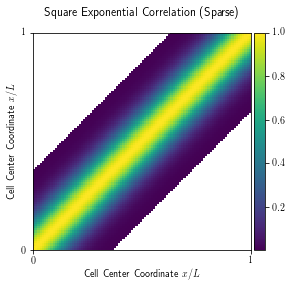

In [6]:
corr_sp = rf.covariance.array_to_sparse(corr, tol=1e-3)
corr_nan = rf.covariance.sparse_to_nan(corr_sp)

# plot
fig, ax = plot_mat(corr_nan)
ax.set_title('Square Exponential Correlation (Sparse)')

#### Varying correlation length scale 
We can also modify the length scale in the correlation structure.

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b3bf87e10>)

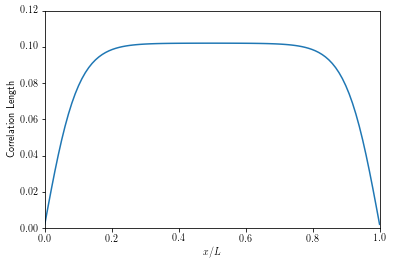

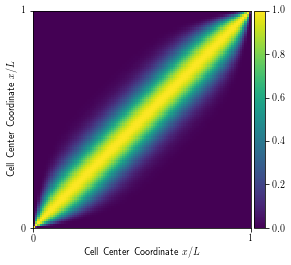

In [7]:
l2 = (1 / (1 + np.exp(-20*x)) - 0.49)*0.2
l2[50:] = l2[49::-1]
corr2 = rf.covariance.kernel_sqrexp(coords=x, length_scales=[l2])

plt.figure()
plt.plot(x, l2)
plt.xlabel('$x/L$')
plt.ylabel('Correlation Length')
plt.xlim([0,1])
plt.ylim([0,0.12])

plot_mat(corr2)

### Covariance
To convert get a covariance matrix using the correlation structure already obtained, we need to define the standard deviatoin at each cell. Here we will use a constant standard deviation of $5$. Note that we can generally provide sparse matrices to the functions in the *covariance* module. The output covariance is a sparse matrix. 

The resulting covariance has the same shape as the correlation (since constant standard deviation was used) but is scaled by $5^2$. 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b3bffc1d0>)

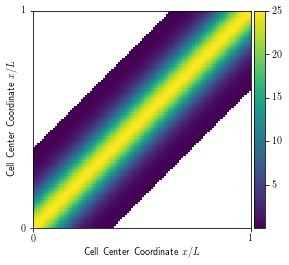

In [8]:
cov = rf.covariance.corr_to_cov(corr_sp, stddev=5)

plot_mat(rf.covariance.sparse_to_nan(cov))

#### Varying Standard Deviation
We can also use different standard deviations in different regions. Here we use a larger variance near the center of the channel. 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6b3bebf050>)

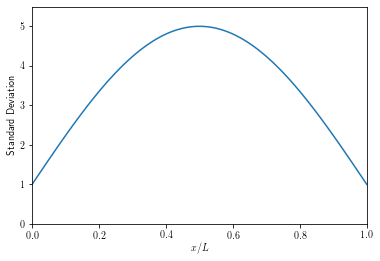

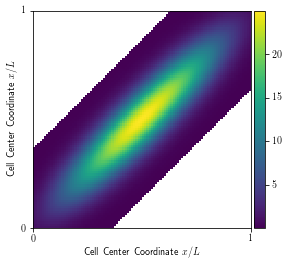

In [9]:
stddev = 4*np.sin(2*np.pi*x/2)+1
cov = rf.covariance.corr_to_cov(corr_sp, stddev)

plt.figure()
plt.plot(x, stddev)
plt.xlabel('$x/L$')
plt.ylabel('Standard Deviation')
plt.xlim([0,1])
plt.ylim([0,5.5])

plot_mat(rf.covariance.sparse_to_nan(cov))

## 2D Example
Now an example using more than one dimension. First lets create the mesh. 

In [10]:
Lx = 4
Ly = 1
nxpoints = 200
nypoints = 100
ncells = nxpoints*nypoints

xpos, ypos = np.meshgrid(np.linspace(0, Lx, nxpoints), np.linspace(0, Ly, nypoints))
xpos = np.atleast_2d(xpos.ravel()).T
ypos = np.atleast_2d(ypos.ravel()).T
coords = np.hstack([xpos, ypos])

This time we will use the *generate_cov* function to do both the correlation structure and covariance in a single step. When calling this function we must specify the kernel (either the name of an implemented kernel or a function that outputs the correlation structure). We must also provide any additional keyword arguments that will be passed to the kernel function. Here we will again use the square exponential and so we need to provide *coordinates* and *correlation length*. In this case the inputs are as follows:
* **kernel**: name (str) of implemented kernel  or function
* **stddev**: standard deviation: float for a constant or 1D array (length number of cells) for a varying. 
* **coords**: corrdinates: in this case array ncellsx2
* **length_scales**: correlation length: list of length number of dimensions. Each entry is either a float for constant or a 1D array (length number of cells) for varying.

In [11]:
stddev=5
length_scales=[0.2, 0.1]

cov = rf.covariance.generate_cov('sqrexp', stddev, coords=coords, length_scales=length_scales)

Unlike the 1D case not much is gained from plotting the covariance matrix. Instead here we plot hte covariance of a a single point with the rest of the field. The correlation length is twice as along in the $x$-direction as expected. 
Change the point below to see the correlation of different points. 

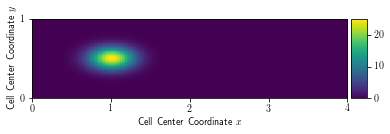

In [12]:
# CHOOSE POINT
point = [1.0, 0.5] # x,y

# get covariance of point
dx = Lx/nxpoints
dy = Ly/nypoints
cell = [int(point[1]/dy), int(point[0]/dx)]
mask = np.zeros([nypoints, nxpoints])
mask[cell[0], cell[1]] = 1
cov_point = cov.todense()[np.argwhere(mask.flatten()==1), :].reshape([nypoints, nxpoints])

# plot
fig, ax = plt.subplots()
im = ax.matshow(np.flipud(cov_point), extent=[0,Lx,0,Ly], interpolation='none')
ax.xaxis.tick_bottom()
ax.set_xlabel('Cell Center Coordinate $x$')
ax.set_ylabel('Cell Center Coordinate $y$')
ax.axis('equal')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)